<a href="https://colab.research.google.com/github/simoa-ufmg/adaptdominio/blob/main/SVMCloro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water

In [ ]:
!pip install adapt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 2.5 MB/s 
  Created wheel for adapt: filename=adapt-0.4.2-py3-none-any.whl size=129084 sha256=b1f55fa0d70d880943b1db52f0576cad645f22a02590c4572fc3cabecd1c16d4
  Stored in directory: /root/.cache/pip/wheels/39/8f/0d/d61cbcd94f98de74678107753ae4b77ed740ed7df9e2c346c3
Successfully built adapt


In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import Counter
from numpy import where

In [ ]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.linear_model import RidgeClassifier
from adapt.utils import make_classification_da
from adapt.feature_based import TCA

from adapt.feature_based import DANN, ADDA, DeepCORAL, CORAL, MCD, MDD, WDGRL, CDAN, FA, SA,fMMD, CCSA
from adapt.instance_based import KMM, LDM, KLIEP, WANN
from adapt.parameter_based import RegularTransferLR, RegularTransferNN, RegularTransferLC, FineTuning, TransferTreeClassifier, TransferForestClassifier

In [ ]:
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [ ]:
url3 = 'https://raw.githubusercontent.com/MaurenSguarioUTFPR/Cemig/main/Clorofila_Pixels_Captura_S2_Dados_Globais_13_Datasets.csv'

data3  = pd.read_csv(url3, header=0, index_col=False, na_values='.');

columns = ["Unnamed: 0" ,"Sample_Date", "Image_Date", "Time_Sample", "Image_Hour", "Station_Sample", "Parameter", "Value", "Unit", "Depth", "Depth_Unit", "Local_Name", "Location_Type", "Lat", "Lon", "Country", "Organization_Data", "Hemisphere", "Season", "Source_Domain", "Diff_Date", "BAND_1", "BAND_2", "BAND_3", "BAND_4", "BAND_5", "BAND_6", "BAND_7", "BAND_8", "BAND_8A", "BAND_9", "BAND_11", "BAND_12", "MSK_CLDPRB", "MSK_SNOW", "QA60", "CLDYPXPER", "DRK_FEA_PE", "NDWI", "NBSI", "Water_Check", "Snow_Check", "Scene_Class", "geometry"]
data3.columns = columns

In [ ]:
#dados = data3.loc[data3['Country'] == 'US']
USA = data3.loc[data3['Source_Domain'] == 'United_States']
Brazil = data3.loc[(data3['Source_Domain'] == 'CEMIG') | (data3['Source_Domain'] == 'Brazil')]

In [ ]:
usa = USA.loc[(USA['MSK_CLDPRB'] <= 0.0) & (USA['MSK_SNOW'] <= 0.0) & (USA['Scene_Class'] == "Water") & (USA['Water_Check'] != "Drought") & (USA['Snow_Check'] == "No_Snow") & (USA['QA60'] <= 0.0)]
br = Brazil.loc[(Brazil['MSK_CLDPRB'] <= 0.0) & (Brazil['MSK_SNOW'] <= 0.0) & (Brazil['Scene_Class'] == "Water") & (Brazil['Water_Check'] != "Drought") & (Brazil['Snow_Check'] == "No_Snow") & (Brazil['QA60'] <= 0.0)]

In [ ]:
mult = 3

std_reference = usa['Value'].std() * mult
lower_std = usa['Value'].mean() - std_reference
upper_std = usa['Value'].mean() + std_reference
std_reference = br['Value'].std() * mult
lower_std = br['Value'].mean() - std_reference
upper_std = br['Value'].mean() + std_reference

In [ ]:
def std_outlier(x):
    if ((x >= lower_std) & (x<=upper_std)):
        return 1
    else:
        return -1

In [ ]:
usa['anomalies_std'] = usa['Value'].apply(std_outlier)
usa = usa.query('anomalies_std == 1')
br['anomalies_std'] = br['Value'].apply(std_outlier)
br = br.query('anomalies_std == 1')

<ipython-input-12-5b1614f7d3c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['anomalies_std'] = usa['Value'].apply(std_outlier)
<ipython-input-12-5b1614f7d3c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['anomalies_std'] = br['Value'].apply(std_outlier)


In [ ]:
del(usa['anomalies_std'])
del(br['anomalies_std'])

In [ ]:
usa = usa.drop_duplicates(['BAND_1','BAND_2','BAND_3'])
br = br.drop_duplicates(['BAND_1','BAND_2','BAND_3'])
usa = usa.loc[(usa['Diff_Date'] <= 0)]
br = br.loc[(br['Diff_Date'] <= 0)]

In [ ]:
usaT = usa.loc[(usa['Parameter'] == "Chlorophyll")]
brT = br.loc[(br["Parameter"] == "Chlorophyll")]

In [ ]:
brT = brT.drop(['Unnamed: 0'], axis=1)
brT = brT.drop(['Time_Sample'], axis=1)
brT = brT.drop(['Image_Hour'], axis=1)
brT = brT.drop(['Station_Sample'], axis=1)
brT = brT.drop(['Sample_Date'], axis=1)
brT = brT.drop(['Image_Date'], axis=1)
brT = brT.drop(['Parameter'], axis=1)
brT = brT.drop(['Unit'], axis=1)
brT = brT.drop(['Depth'], axis=1)
brT = brT.drop(['Depth_Unit'], axis=1)
brT = brT.drop(['Local_Name'], axis=1)
brT = brT.drop(['Location_Type'], axis=1)
brT = brT.drop(['Country'], axis=1)
brT = brT.drop(['Hemisphere'], axis=1)

In [ ]:
usaT = usaT.drop(['Unnamed: 0'], axis=1)
usaT = usaT.drop(['Time_Sample'], axis=1)
usaT = usaT.drop(['Image_Hour'], axis=1)
usaT = usaT.drop(['Station_Sample'], axis=1)
usaT = usaT.drop(['Sample_Date'], axis=1)
usaT = usaT.drop(['Image_Date'], axis=1)
usaT = usaT.drop(['Parameter'], axis=1)
usaT = usaT.drop(['Unit'], axis=1)
usaT = usaT.drop(['Depth'], axis=1)
usaT = usaT.drop(['Depth_Unit'], axis=1)
usaT = usaT.drop(['Local_Name'], axis=1)
usaT = usaT.drop(['Location_Type'], axis=1)
usaT = usaT.drop(['Country'], axis=1)
usaT = usaT.drop(['Hemisphere'], axis=1)

In [ ]:
brT = brT.drop(['Season'], axis=1)
brT = brT.drop(['Source_Domain'], axis=1)
brT = brT.drop(['Diff_Date'], axis=1)
brT = brT.drop(['MSK_CLDPRB'], axis=1)
brT = brT.drop(['MSK_SNOW'], axis=1)
brT = brT.drop(['CLDYPXPER'], axis=1)
brT = brT.drop(['QA60'], axis=1)
brT = brT.drop(['DRK_FEA_PE'], axis=1)
brT = brT.drop(['NDWI'], axis=1)
brT = brT.drop(['NBSI'], axis=1)
brT = brT.drop(['Water_Check'], axis=1)
brT = brT.drop(['Snow_Check'], axis=1)
brT = brT.drop(['Scene_Class'], axis=1)
brT = brT.drop(['geometry'], axis=1)

In [ ]:
usaT = usaT.drop(['Season'], axis=1)
usaT = usaT.drop(['Source_Domain'], axis=1)
usaT = usaT.drop(['Diff_Date'], axis=1)
usaT = usaT.drop(['MSK_CLDPRB'], axis=1)
usaT = usaT.drop(['MSK_SNOW'], axis=1)
usaT = usaT.drop(['CLDYPXPER'], axis=1)
usaT = usaT.drop(['QA60'], axis=1)
usaT = usaT.drop(['DRK_FEA_PE'], axis=1)
usaT = usaT.drop(['NDWI'], axis=1)
usaT = usaT.drop(['NBSI'], axis=1)
usaT = usaT.drop(['Water_Check'], axis=1)
usaT = usaT.drop(['Snow_Check'], axis=1)
usaT = usaT.drop(['Scene_Class'], axis=1)
usaT = usaT.drop(['geometry'], axis=1)


# Dados 

In [ ]:
def classifica_uso_residencial_malasia(x):
        if x <= 25:
            return "0"
        else:
            return '1'

In [ ]:
usaT['Classe'] = usaT['Value'].apply(classifica_uso_residencial_malasia)
brT['Classe'] = brT['Value'].apply(classifica_uso_residencial_malasia)

Pitsburg long -79.995888   lat 40.440624
Chicago  long -87.623177   lat 41.881832
Denver   long -104.991531  lat 39.742043
Miami    long -80.191788   lat 25.761681

# Dataset 80 treino 20 teste

In [ ]:
#Xt = usaT[usaT['Lon'] < -100.991531]
#Xs = usaT[usaT['Lon'] >= -100.991531]
Xs = usaT
Xt = brT

In [ ]:
Xs = Xs.fillna(Xs.median(numeric_only=True))
Xt = Xt.fillna(Xt.median(numeric_only=True))

In [ ]:
Xs = Xs.drop(['Value'], axis=1)
Xs = Xs.drop(['Lat'], axis=1)
Xs = Xs.drop(['Lon'], axis=1)
Xs = Xs.drop(['Organization_Data'], axis=1)

In [ ]:
Xt = Xt.drop(['Value'], axis=1)
Xt = Xt.drop(['Lat'], axis=1)
Xt = Xt.drop(['Lon'], axis=1)
Xt = Xt.drop(['Organization_Data'], axis=1)

In [ ]:
bandas = ['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']
Xs[bandas] = Xs[bandas].multiply(0.0001)
Xt[bandas] = Xt[bandas].multiply(0.0001)

In [ ]:
array = Xs.values
Xs = array[:, 0:12].astype(float)
ys = array[:, 12].astype(int)

In [ ]:
array = Xt.values
Xt = array[:, 0:12].astype(float)
yt = array[:, 12].astype(int)

In [ ]:
print("train_set size: {} - Class0: {}, Class1: {}, Class2: {}".format( len(ys), len(ys[ys == 0]), len(ys[ys == 1]), len(ys[ys == 2]) ))
print("test_set size: {} - Class0: {}, Class1: {}, Class2: {}".format( len(yt), len(yt[yt == 0]), len(yt[yt == 1]), len(yt[yt == 2]) ))

train_set size: 4460 - Class0: 3615, Class1: 845, Class2: 0
test_set size: 115 - Class0: 85, Class1: 30, Class2: 0


#Smote

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where
from matplotlib import pyplot

In [ ]:
# transform the dataset train
oversample = SMOTE()
Xs, ys = oversample.fit_resample(Xs, ys)

In [ ]:
print("train_set size: {} - Class0: {}, Class1: {}, Class2: {}, Class3: {}".format( len(ys), len(ys[ys == 0]), len(ys[ys == 1]), len(ys[ys == 2]), len(ys[ys == 3]) ))
print("test_set size: {} - Class0: {}, Class1: {}, Class2: {}, Class3: {}".format( len(yt), len(yt[yt == 0]), len(yt[yt == 1]), len(yt[yt == 2]), len(yt[yt == 3]) ))

train_set size: 7230 - Class0: 3615, Class1: 3615, Class2: 0, Class3: 0
test_set size: 115 - Class0: 85, Class1: 30, Class2: 0, Class3: 0


#Results

In [ ]:
std_sc = StandardScaler().fit(np.concatenate((Xs, Xt)))
Xs = std_sc.transform(Xs)
Xt = std_sc.transform(Xt)

In [ ]:
def show_results2(model, is_src_only=False):
  
  ys_pred = model.predict(Xs)
  yt_pred = model.predict(Xt)
  acc_s = accuracy_score(ys, ys_pred>0.5)
  acc_t = accuracy_score(yt, yt_pred>0.5)


  cmT = confusion_matrix(yt, yt_pred>0.5)
  cm_display = ConfusionMatrixDisplay(cmT).plot()
  

  print(classification_report(yt, yt_pred))  
  
  if is_src_only:
  
    print("Accuracy, source : %f" % acc_s)
    print("Balanced accuracy, source : %f" % balanced_accuracy_score(ys, ys_pred>0.5))
    print("Precision, source: %f" % precision_score(ys, ys_pred>0.5))
    print("Recall, source: %f" % recall_score(ys, ys_pred>0.5))
    print("F1, source: %f" % f1_score(ys, ys_pred>0.5))
    print("Area under curve (auc):, source: %f" % roc_auc_score(ys, ys_pred>0.5))
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))
    print("Area under curve (auc):, target: %f" % roc_auc_score(yt, yt_pred>0.5))
  else: 
    
    print("Accuracy, source : %f" % acc_s)
    print("Balanced accuracy, source : %f" % balanced_accuracy_score(ys, ys_pred>0.5))
    print("Precision, source: %f" % precision_score(ys, ys_pred>0.5))
    print("Recall, source: %f" % recall_score(ys, ys_pred>0.5))
    print("F1, source: %f" % f1_score(ys, ys_pred>0.5))
    print("Area under curve (auc):, source: %f" % roc_auc_score(ys, ys_pred>0.5))
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))
    print("Area under curve (auc):, target: %f" % roc_auc_score(yt, yt_pred>0.5))
 


In [ ]:
def show_results(model, is_src_only=False):
  
  ys_pred = model.predict(Xs)
  yt_pred = model.predict(Xt)
  acc_s = accuracy_score(ys, ys_pred>0.5)
  acc_t = accuracy_score(yt, yt_pred>0.5)

  print(classification_report(yt, yt_pred>0.5))

  if is_src_only:
    print("ok")
    print("Accuracy, source : %f" % acc_s)
    print("Balanced accuracy, source : %f" % balanced_accuracy_score(ys, ys_pred>0.5))
    print("Precision, source: %f" % precision_score(ys, ys_pred>0.5))
    print("Recall, source: %f" % recall_score(ys, ys_pred>0.5))
    print("F1, source: %f" % f1_score(ys, ys_pred>0.5))
    print("Area under curve (auc):, source: %f" % roc_auc_score(ys, ys_pred>0.5))
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))
    print("Area under curve (auc):, target: %f" % roc_auc_score(yt, yt_pred>0.5))
  else:  
    cmT = confusion_matrix(yt, yt_pred>0.5)
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    #print("Precision, target: %f" % precision_score(yt, yt_pred>0.5, average='weighted'))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))

  
 

# SVM

In [ ]:
x_min = np.min(Xs.min(0))
y_min = np.min(Xt.min(0))
x_max = np.max(Xs.max(0))
y_max = np.max(Xt.max(0))

In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 

# fit classifier to training set
poly_svc100.fit(Xs, ys)

# make predictions on test set
y_pred=poly_svc100.predict(Xt)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(yt, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.8000


              precision    recall  f1-score   support

           0       0.91      0.81      0.86        85
           1       0.59      0.77      0.67        30

    accuracy                           0.80       115
   macro avg       0.75      0.79      0.76       115
weighted avg       0.82      0.80      0.81       115

Accuracy, source : 0.856570
Balanced accuracy, source : 0.856570
Precision, source: 0.827324
Recall, source: 0.901245
F1, source: 0.862704
Area under curve (auc):, source: 0.856570
Accuracy, target : 0.800000
Balanced accuracy, target : 0.789216
Precision, target: 0.589744
Recall, target: 0.766667
F1, target: 0.666667
Area under curve (auc):, target: 0.789216


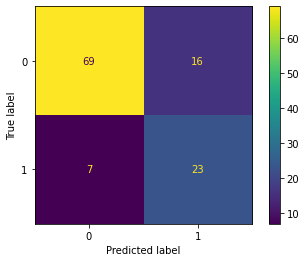

In [ ]:
show_results2(poly_svc100)

#DANN

In [ ]:
dann = DANN(lambda_=0.1, Xt=Xt, metrics=["acc"], random_state=0)
dann.fit(Xs, ys, epochs=100, verbose=0)
dann.score(Xt, yt)

1/1 [==============================] - 0s 179ms/step - loss: 0.1606 - acc: 0.7652


0.16057877242565155

In [ ]:
show_results(dann, True)

              precision    recall  f1-score   support

           0       0.90      0.76      0.83        85
           1       0.53      0.77      0.63        30

    accuracy                           0.77       115
   macro avg       0.72      0.77      0.73       115
weighted avg       0.81      0.77      0.78       115

ok
Accuracy, source : 0.884786
Balanced accuracy, source : 0.884786
Precision, source: 0.862617
Recall, source: 0.915353
F1, source: 0.888203
Area under curve (auc):, source: 0.884786
Accuracy, target : 0.765217
Balanced accuracy, target : 0.765686
Precision, target: 0.534884
Recall, target: 0.766667
F1, target: 0.630137
Area under curve (auc):, target: 0.765686


ADDA

In [ ]:
adda = ADDA(Xt=Xt, metrics=["acc"], random_state=0)
adda.fit(Xs, ys, epochs=800, verbose=0)
adda.score(Xt, yt)

1/1 [==============================] - 0s 227ms/step - loss: 0.3851 - acc: 0.5217


0.3850644528865814

In [ ]:
show_results(adda, True)

              precision    recall  f1-score   support

           0       0.78      0.49      0.60        85
           1       0.30      0.60      0.40        30

    accuracy                           0.52       115
   macro avg       0.54      0.55      0.50       115
weighted avg       0.65      0.52      0.55       115

ok
Accuracy, source : 0.643707
Balanced accuracy, source : 0.643707
Precision, source: 0.614000
Recall, source: 0.773997
F1, source: 0.684777
Area under curve (auc):, source: 0.643707
Accuracy, target : 0.521739
Balanced accuracy, target : 0.547059
Precision, target: 0.295082
Recall, target: 0.600000
F1, target: 0.395604
Area under curve (auc):, target: 0.547059


WDGRL

In [ ]:
wdgrl = WDGRL(lambda_=1., gamma=1., Xt=Xt, metrics=["acc"], random_state=0)
wdgrl.fit(Xs, ys, epochs=800, verbose=0)
wdgrl.score(Xt, yt)

1/1 [==============================] - 0s 126ms/step - loss: 0.1377 - acc: 0.8174


0.1376761496067047

In [ ]:
show_results(wdgrl, True)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        85
           1       0.62      0.80      0.70        30

    accuracy                           0.82       115
   macro avg       0.77      0.81      0.78       115
weighted avg       0.84      0.82      0.82       115

ok
Accuracy, source : 0.901660
Balanced accuracy, source : 0.901660
Precision, source: 0.878519
Recall, source: 0.932227
F1, source: 0.904577
Area under curve (auc):, source: 0.901660
Accuracy, target : 0.817391
Balanced accuracy, target : 0.811765
Precision, target: 0.615385
Recall, target: 0.800000
F1, target: 0.695652
Area under curve (auc):, target: 0.811765


CDAN

KMM

In [ ]:
kmm = KMM(
    estimator=SVC(kernel='poly', C=100.0) ,
    Xt=Xt,
    gamma=1.,     # Bandwidth of the kernel
    verbose=0,
    random_state=0
)

In [ ]:
# Fit the model.
kmm.fit(Xs, ys);

# Get the score on target data
kmm.score(Xt, yt)

0.8347826086956521

              precision    recall  f1-score   support

           0       0.89      0.88      0.89        85
           1       0.68      0.70      0.69        30

    accuracy                           0.83       115
   macro avg       0.79      0.79      0.79       115
weighted avg       0.84      0.83      0.84       115

Accuracy, source : 0.837068
Balanced accuracy, source : 0.837068
Precision, source: 0.844891
Recall, source: 0.825726
F1, source: 0.835199
Area under curve (auc):, source: 0.837068
Accuracy, target : 0.834783
Balanced accuracy, target : 0.791176
Precision, target: 0.677419
Recall, target: 0.700000
F1, target: 0.688525
Area under curve (auc):, target: 0.791176


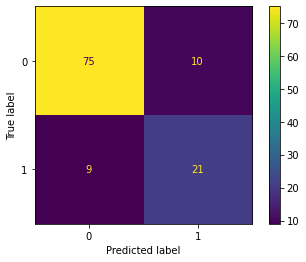

In [ ]:
show_results2(kmm, True)

Coral

In [ ]:
coral = CORAL(
    estimator=SVC(kernel='poly', C=100.0), 
    Xt=Xt, random_state=0)

coral.fit(Xs, ys)
coral.score(Xt, yt)

Fit transform...
Previous covariance difference: 0.179278
New covariance difference: 0.000002
Fit Estimator...


0.7652173913043478

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        85
           1       0.54      0.70      0.61        30

    accuracy                           0.77       115
   macro avg       0.71      0.74      0.72       115
weighted avg       0.79      0.77      0.77       115

Accuracy, source : 0.821024
Balanced accuracy, source : 0.821024
Precision, source: 0.818207
Recall, source: 0.825450
F1, source: 0.821812
Area under curve (auc):, source: 0.821024
Accuracy, target : 0.765217
Balanced accuracy, target : 0.744118
Precision, target: 0.538462
Recall, target: 0.700000
F1, target: 0.608696
Area under curve (auc):, target: 0.744118


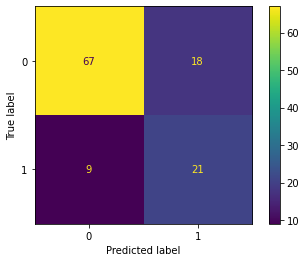

In [ ]:
show_results2(coral, True)

TCA

In [ ]:
#tca = TCA(estimator=SVC(kernel='poly', C=100.0), Xt=Xt, n_components=1, mu=0.1, 
            #kernel="rbf", gamma=0.1, verbose=0, random_state=0)

In [ ]:
#tca.fit(Xs, ys)
#tca.score(Xt, yt)      

In [ ]:
#show_results2(tca, True)

FA

In [ ]:
fa = FA(estimator=SVC(kernel='poly', C=100.0), Xt=Xt[:10], yt=yt[:10], random_state=0)

Fit transform...
Previous shape: (7230, 12)
New shape: (7240, 36)
Fit Estimator...
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        85
           1       0.42      0.83      0.56        30

    accuracy                           0.65       115
   macro avg       0.66      0.71      0.63       115
weighted avg       0.78      0.65      0.67       115

Accuracy, source : 0.598617
Balanced accuracy, source : 0.598617
Precision, source: 0.567995
Recall, source: 0.823790
F1, source: 0.672387
Area under curve (auc):, source: 0.598617
Accuracy, target : 0.652174
Balanced accuracy, target : 0.710784
Precision, target: 0.416667
Recall, target: 0.833333
F1, target: 0.555556
Area under curve (auc):, target: 0.710784


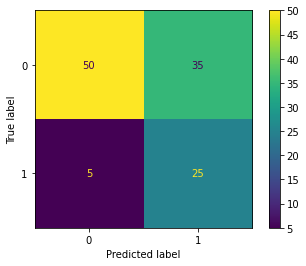

In [ ]:
fa.fit(Xs, ys)
fa.score(Xt, yt)
show_results2(fa, True) 

SA

In [ ]:
sa = SA(estimator=SVC(kernel='poly', C=100.0), Xt=Xt, random_state=0)
sa.fit(Xs, ys)
sa.score(Xt, yt)

Fit transform...
Fit Estimator...


0.6695652173913044

              precision    recall  f1-score   support

           0       0.94      0.59      0.72        85
           1       0.44      0.90      0.59        30

    accuracy                           0.67       115
   macro avg       0.69      0.74      0.66       115
weighted avg       0.81      0.67      0.69       115

Accuracy, source : 0.712172
Balanced accuracy, source : 0.712172
Precision, source: 0.636283
Recall, source: 0.990595
F1, source: 0.774857
Area under curve (auc):, source: 0.712172
Accuracy, target : 0.669565
Balanced accuracy, target : 0.744118
Precision, target: 0.435484
Recall, target: 0.900000
F1, target: 0.586957
Area under curve (auc):, target: 0.744118


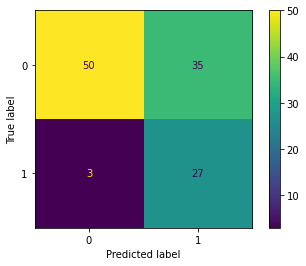

In [ ]:
show_results2(sa, True)

fMMD

In [ ]:
fmmd = fMMD(estimator=SVC(kernel='poly', C=100.0),
             Xt=Xt, kernel="linear", random_state=0, verbose=0)
fmmd.fit(Xs, ys)
fmmd.score(Xt, yt)
show_results2(fmmd, True)

KeyboardInterrupt: ignored

MDD

In [ ]:
mdd = MDD(lambda_=0.1, gamma=4., Xt=Xt, metrics=["acc"], random_state=0)
mdd.fit(Xs, ys, epochs=100, verbose=0)
mdd.score(Xt, yt)

In [ ]:
show_results(mdd, True)

#cdan

In [ ]:
ys = np.stack([ys, np.abs(1-ys)], 1)
yt = np.stack([yt, np.abs(1-yt)], 1)
cdan = CDAN(lambda_=0.1, Xt=Xt, metrics=["acc"], random_state=0)
cdan.fit(Xs, ys, epochs=100, verbose=0)
cdan.score(Xt, yt)

1/1 [==============================] - 0s 112ms/step - loss: 0.1581 - acc: 0.7857


0.15806157886981964

In [ ]:
ys_pred = cdan.predict(Xs)
yt_pred = cdan.predict(Xt)
acc_s = accuracy_score(ys, ys_pred>0.5)
acc_t = accuracy_score(yt, yt_pred>0.5)

print(classification_report(yt, yt_pred>0.5))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1046
           1       0.82      0.69      0.75       914

   micro avg       0.79      0.79      0.79      1960
   macro avg       0.79      0.78      0.78      1960
weighted avg       0.79      0.79      0.78      1960
 samples avg       0.79      0.79      0.79      1960



In [ ]:
print("Accuracy, target : %f" % acc_t)
print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    
    

Accuracy, target : 0.785714


ValueError: ignored